In [1]:
import numpy as np 
import pandas as pd 
from numba import njit
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import cv2 as cv
from sklearn import svm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.decomposition import PCA
from glob import glob
from skimage import io
from os import listdir
import pickle
import time
import copy

In [2]:
data = listdir('./breast-histopathology-images/IDC_regular_ps50_idx5/')

In [3]:
print(len(data))

279


In [4]:
base_path = './breast-histopathology-images/IDC_regular_ps50_idx5/'
patients = listdir(base_path)

In [5]:
patients[:5]

['10253', '10254', '10255', '10256', '10257']

In [6]:
class_0 = 0
class_1 = 0
for patient in patients:
    class_0_files = listdir(base_path + patient + '/0')
    class_1_files = listdir(base_path + patient + '/1')

    class_0 += len(class_0_files)
    class_1 += len(class_1_files) 

images = class_0 + class_1

In [7]:
class_0 

198740

In [8]:
class_1

78786

In [9]:
images

277526

In [7]:
data = pd.DataFrame(index=np.arange(0, images), columns=["patient_id", "path", "target"])
#got help from https://www.kaggle.com/allunia/breastcancer
k = 0
for n in range(len(patients)):
    patient_id = patients[n]
    patient_path = base_path + patient_id 
    for c in [0,1]:
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        for m in range(len(subfiles)):
            image_path = subfiles[m]
            data.iloc[k]["path"] = class_path + image_path
            data.iloc[k]["target"] = c
            data.iloc[k]["patient_id"] = patient_id
            k += 1  

data.head()

,patient_id,path,target
0,10253,./breast-histopathology-images/IDC_regular_ps5...,0
1,10253,./breast-histopathology-images/IDC_regular_ps5...,0
2,10253,./breast-histopathology-images/IDC_regular_ps5...,0
3,10253,./breast-histopathology-images/IDC_regular_ps5...,0
4,10253,./breast-histopathology-images/IDC_regular_ps5...,0


In [11]:
data.tail()

,patient_id,path,target
277521,9383,./breast-histopathology-images/IDC_regular_ps5...,1
277522,9383,./breast-histopathology-images/IDC_regular_ps5...,1
277523,9383,./breast-histopathology-images/IDC_regular_ps5...,1
277524,9383,./breast-histopathology-images/IDC_regular_ps5...,1
277525,9383,./breast-histopathology-images/IDC_regular_ps5...,1


In [12]:
data.shape

(277526, 3)

In [11]:
data.dtypes

patient_id    object
path          object
target        object
dtype: object

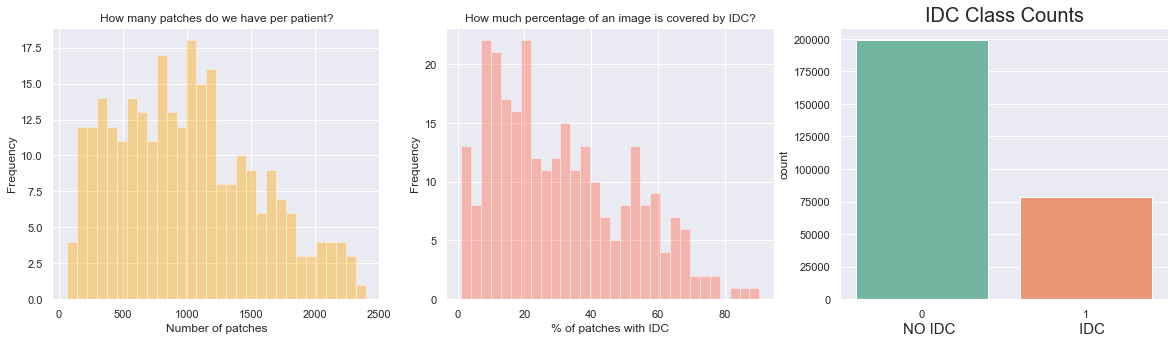

In [16]:
cancer_perc = data.groupby("patient_id").target.value_counts()/ data.groupby("patient_id").target.size()
cancer_perc = cancer_perc.unstack()

fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.distplot(data.groupby("patient_id").size(), ax=ax[0], color="Orange", kde=False, bins=30)
ax[0].set_xlabel("Number of patches")
ax[0].set_ylabel("Frequency");
ax[0].set_title("How many patches do we have per patient?");
sns.distplot(cancer_perc.loc[:, 1]*100, ax=ax[1], color="Tomato", kde=False, bins=30)
ax[1].set_title("How much percentage of an image is covered by IDC?")
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("% of patches with IDC");
sns.countplot(data.target, palette="Set2", ax=ax[2]);
ax[2].set_xlabel("NO IDC                              IDC", fontsize=15)
ax[2].set_title("IDC Class Counts", fontsize=20);

In [13]:
data.target = data.target.astype(np.int)

In [14]:
pos_selection = np.random.choice(data[data.target==1].index.values, size=50, replace=False)
neg_selection = np.random.choice(data[data.target==0].index.values, size=50, replace=False)

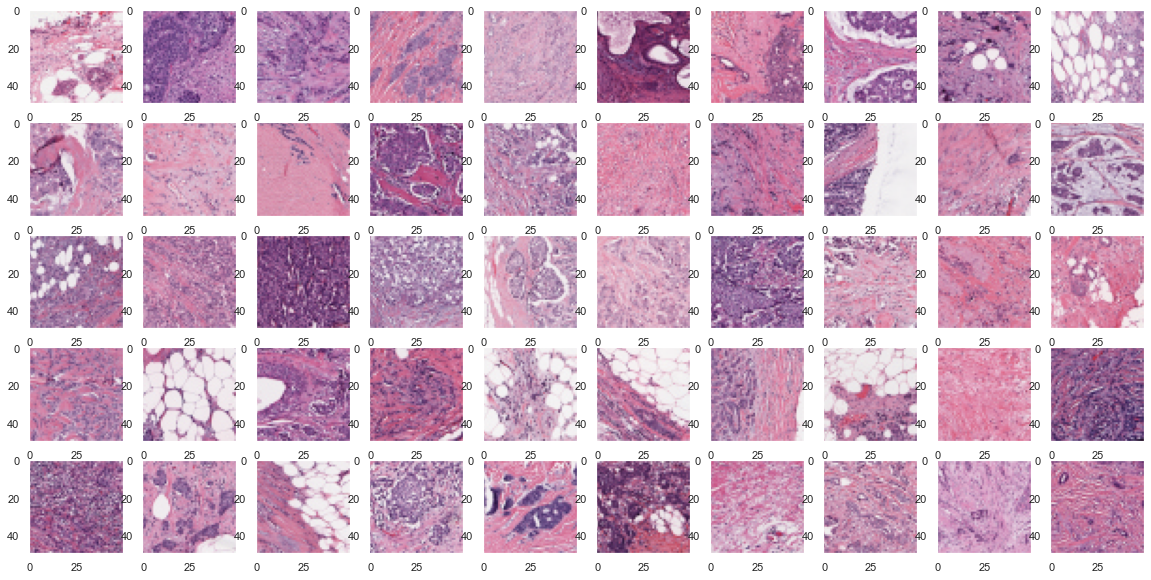

In [15]:
fig, ax = plt.subplots(5,10,figsize=(20,10))
from skimage.io import imread
for n in range(5):
    for m in range(10):
        idx = pos_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

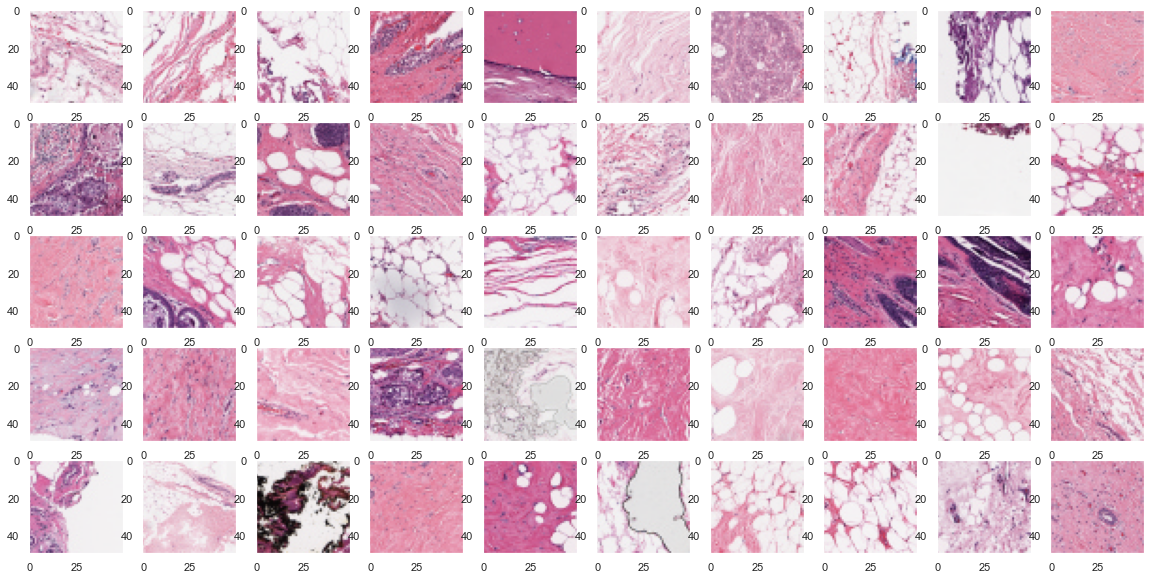

In [20]:
fig, ax = plt.subplots(5,10,figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = neg_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

In [19]:
data.isnull().sum()

patient_id    0
path          0
target        0
dtype: int64